In [1]:
# import all packages and libraries needed to run the code

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
# import the training set and the unlabeled test set  
X_train = pd.read_csv("training_v2.csv")
unlabeled = pd.read_csv("unlabeled.csv")

# drop features that are not expected to be related to the outcome
X_train.drop(['hospital_id', 'patient_id', 'icu_id', 'readmission_status'], inplace=True, axis=1)
unlabeled.drop(['hospital_id', 'patient_id', 'icu_id', 'readmission_status', 'hospital_death'], 
inplace=True, axis=1)

print(X_train.shape)
print(unlabeled.shape)

(91713, 182)
(39308, 181)


In [3]:
# impute height and weight with average values assuming that males are taller and heavier than females
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender == 'F')), 160, X_train["height"])
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender == 'M')), 180, X_train["height"])
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender.isna())), 170, X_train["height"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender == 'F')), 65, X_train["weight"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender == 'M')), 82, X_train["weight"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender.isna())), 74, X_train["weight"])

unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'F')), 160, unlabeled["height"])
unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'M')), 180, unlabeled["height"])
unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender.isna())), 170, unlabeled["height"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'F')), 65, unlabeled["weight"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'M')), 82, unlabeled["weight"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender.isna())), 74, unlabeled["weight"])

No handles with labels found to put in legend.


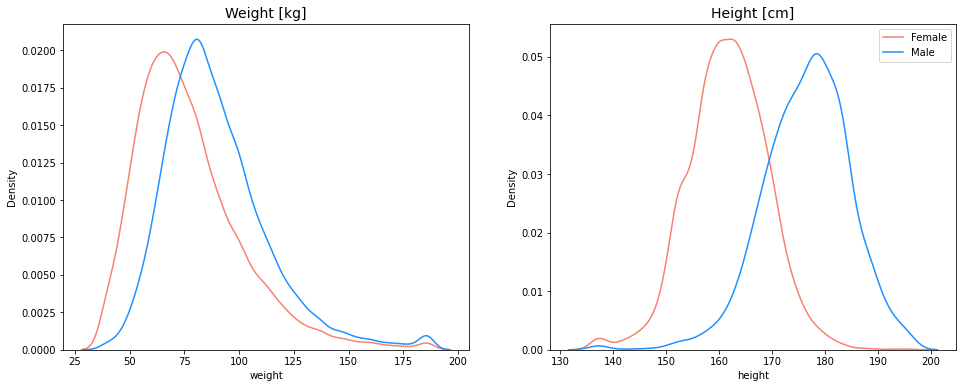

In [5]:
# Check that the distribution of height and weight in the data is approximately normal
# Plot univariate or bivariate distributions using kernel density estimation.
# A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations 
# in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density 
# curve in one or more dimensions.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.kdeplot(X_train[X_train.gender == 'F'].weight, label='Female', color='salmon', ax=ax[0], bw_adjust=1.2)
sns.kdeplot(X_train[X_train.gender == 'M'].weight, label='Male', color='dodgerblue', ax=ax[0], bw_adjust=1.2)
ax[0].set_title('Weight [kg]', fontsize=14)

sns.kdeplot(X_train[X_train.gender == 'F'].height, label='Female', color='salmon', ax=ax[1], bw_adjust=1.8)
sns.kdeplot(X_train[X_train.gender == 'M'].height, label='Male', color='dodgerblue', ax=ax[1], bw_adjust=2)
ax[1].set_title('Height [cm]', fontsize=14)
plt.legend()

plt.show()

In [6]:
# find the number of missing values in each column and divide by column length
lst = X_train.isna().sum() / len(X_train)

# create a dataframe containing the percentage of missing values in each column
p = pd.DataFrame(lst)

# When we reset the index, the old index is added as a column, and a new sequential index is used
p.reset_index(inplace=True)

# find columns containing more than 30% missing values
p.columns = ['a', 'b']
low_count = p[p['b'] > 0.3]
todelete = low_count['a'].values

# drop columns containing more than 30% missing values from the training and unlabeled datasets
X_train.drop(todelete, axis=1, inplace=True)
unlabeled.drop(todelete, axis=1, inplace=True)

X_train.shape

(91713, 108)

In [7]:
# drop rows ontaining more than 30% missing values from the training dataset
X_train.dropna(thresh=X_train.shape[1]*0.3, inplace=True)
X_train.shape

(91679, 108)

In [8]:
y_train = X_train['hospital_death']
X_train.drop('hospital_death', inplace=True, axis=1)

In [2]:
dictionary_ = pd.read_csv("WiDS Datathon 2020 Dictionary.csv")
print(dictionary_.shape)

(188, 6)


In [3]:
integer_cols = []
binary_cols = []
numeric_cols = []
string_cols = []

for i in range(dictionary_.shape[0]):
    if dictionary_.loc[i, 'Data Type'] == 'integer':
        integer_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'binary':
        binary_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'numeric':
        numeric_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'string':
        string_cols.append(dictionary_.loc[i, 'Variable Name'])

In [11]:
for col_name in string_cols:
    if col_name in X_train.columns.to_list():
        X_train[col_name].where(pd.notnull(X_train[col_name]), None, inplace=True)

    if col_name in unlabeled.columns.to_list():
        unlabeled[col_name].where(pd.notnull(unlabeled[col_name]), None, inplace=True)

In [12]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

for col_name in string_cols:
    if col_name in X_train.columns.to_list():
        X_train[col_name] = enc.fit_transform(X_train[[col_name]])

    if col_name in unlabeled.columns.to_list():
        unlabeled[col_name] = enc.fit_transform(unlabeled[[col_name]])

In [13]:
X_train = X_train.astype('float32')
unlabeled = unlabeled.astype('float32')

print(X_train.shape)
print(unlabeled.shape)

(91679, 107)
(39308, 107)


In [14]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='distance', 
metric='nan_euclidean', copy=False)

knn_imputer.fit(X_train)

KNNImputer(copy=False, weights='distance')

In [15]:
knn_imputer.transform(X_train)
knn_imputer.transform(unlabeled)

array([[2.0000000e+00, 5.6000000e+01, 2.1102440e+01, ..., 0.0000000e+00,
        7.0000000e+00, 4.0000000e+00],
       [5.0000000e+00, 6.1099613e+01, 1.9500595e+01, ..., 0.0000000e+00,
        7.0000000e+00, 4.0000000e+00],
       [7.0000000e+00, 6.6000000e+01, 3.2518597e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.3103900e+05, 7.1000000e+01, 2.3010380e+01, ..., 1.0000000e+00,
        9.0000000e+00, 0.0000000e+00],
       [1.3104100e+05, 5.7000000e+01, 3.2987949e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.3105000e+05, 6.6000000e+01, 2.3183392e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [16]:
X_train.to_pickle("X_train_knn.csv")
unlabeled.to_pickle("unlabeled_1_knn.csv")
y_train.to_pickle("y_train_knn.csv")

In [4]:
X_train = pd.read_pickle("X_train_knn.csv")
y_train = pd.read_pickle("y_train_knn.csv")
unlabeled = pd.read_pickle("unlabeled_1_knn.csv")

In [5]:
num_feature = []

for col_name in numeric_cols:
    if col_name in X_train.columns.to_list():
        num_feature.append(col_name)

In [6]:
# Create correlation matrix
corr_matrix = X_train[num_feature].corr().abs()

<AxesSubplot:>

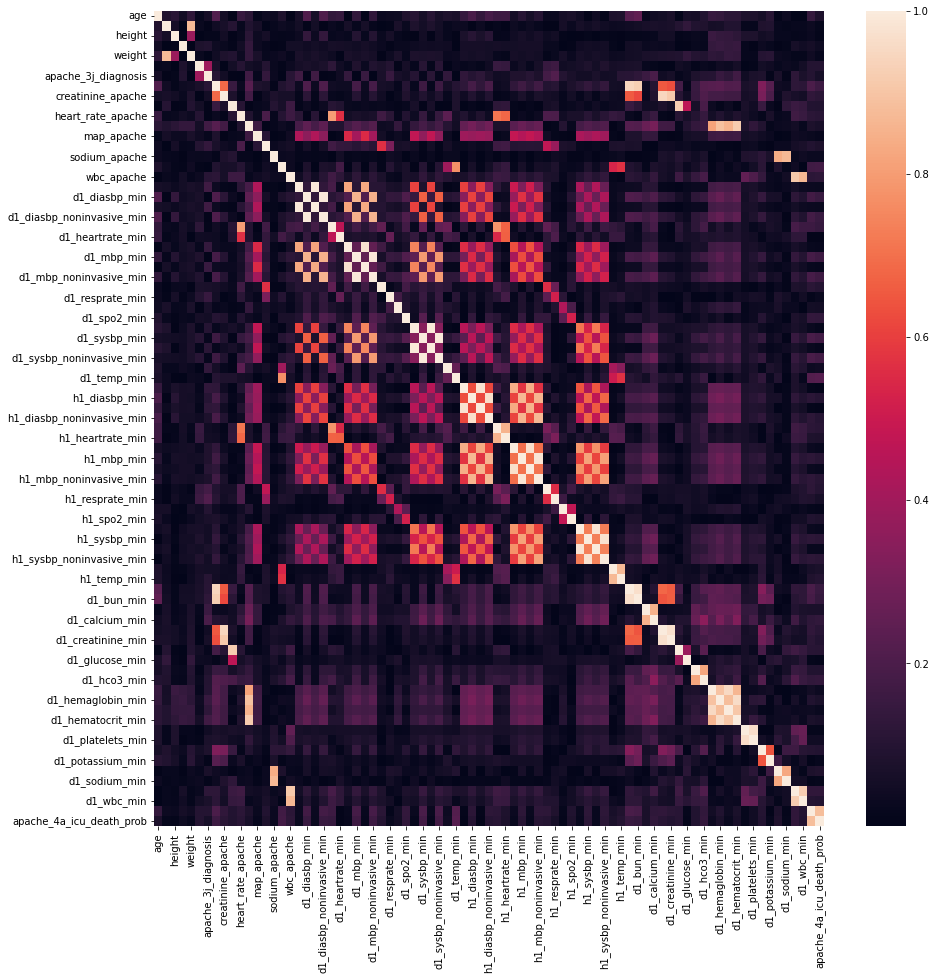

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix)

In [7]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

Text(0, 0.5, 'number of columns to drop')

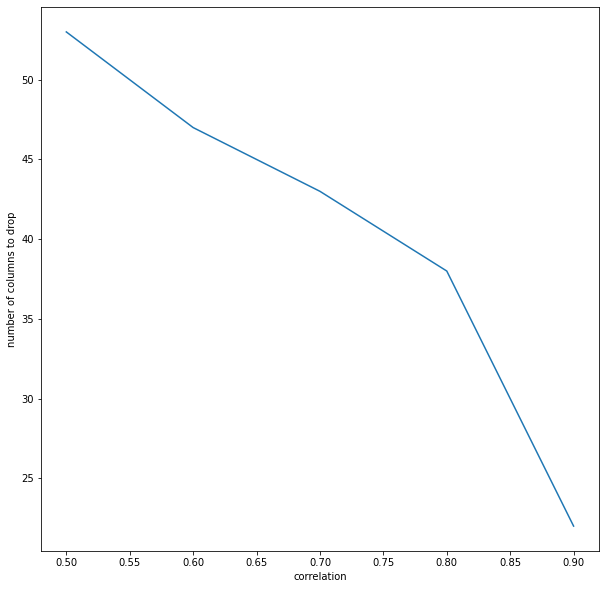

In [8]:
corr = []
to_drop_columns = []

for i in np.arange(0.5, 1, 0.1):
    to_drop = [column for column in upper.columns if any(upper[column] > i)]
    corr.append(i)
    to_drop_columns.append(len(to_drop))

plt.subplots(figsize=(10, 10))
plt.plot(corr, to_drop_columns)
plt.xlabel('correlation')
plt.ylabel('number of columns to drop')

In [9]:
# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

X_train.drop(to_drop, inplace=True, axis=1)
unlabeled.drop(to_drop, inplace=True, axis=1)

print(X_train.shape)
print(unlabeled.shape)

(91679, 69)
(39308, 69)


In [10]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=1000, max_samples=1000, contamination='auto', 
max_features=10, bootstrap=False, n_jobs=-1, random_state=20)

yhat = iso.fit_predict(X_train)

scores = iso.decision_function(X_train)

# select all rows that are not outliers
mask = yhat != -1

np.unique(mask, return_counts=True)

(array([False,  True]), array([ 1804, 89875], dtype=int64))

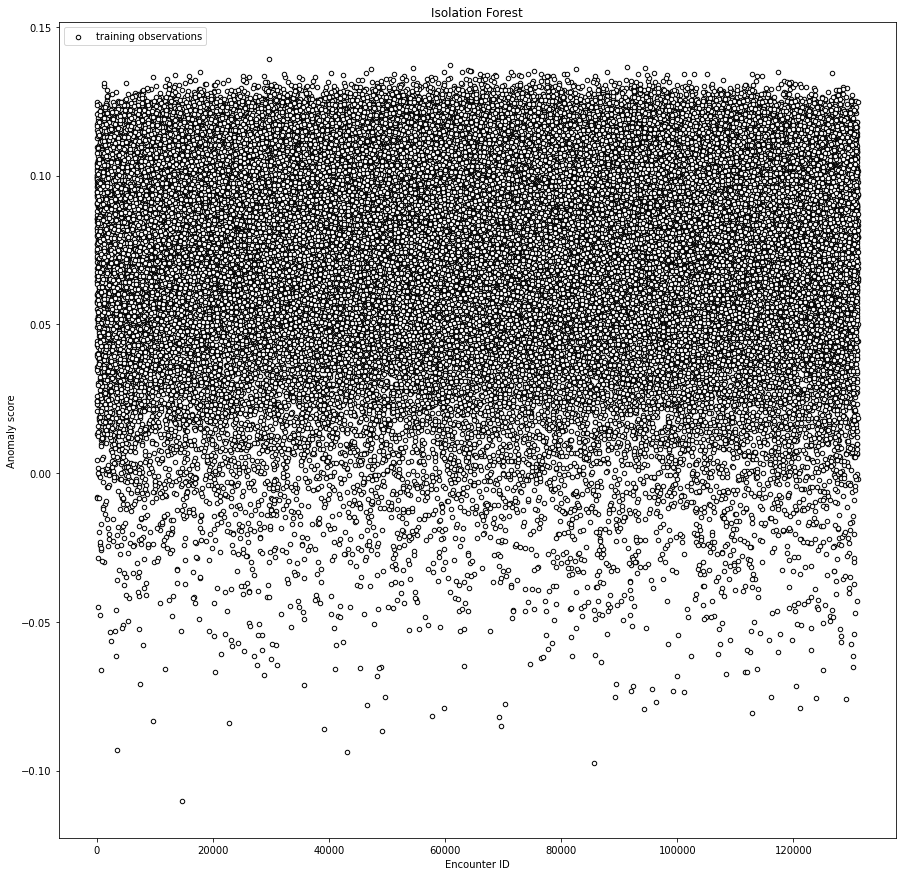

In [11]:
plt.subplots(figsize=(15, 15))
plt.title("Isolation Forest")

b = plt.scatter(X_train['encounter_id'], scores, c='white', s=20, edgecolor='k')

plt.axis('tight')
plt.legend([b], ["training observations"], loc="upper left")
plt.xlabel('Encounter ID')
plt.ylabel('Anomaly score')
plt.show()

In [12]:
X_train = X_train.loc[mask]
y_train = y_train.loc[mask]

In [13]:
from sklearn.preprocessing import StandardScaler

num_feature = []

for col_name in numeric_cols:
    if col_name in X_train.columns.to_list():
        num_feature.append(col_name)

scalar = StandardScaler()

scalar.fit(X_train[num_feature])

X_train[num_feature] = scalar.transform(X_train[num_feature])
unlabeled[num_feature] = scalar.transform(unlabeled[num_feature])

In [14]:
X_train.to_pickle("X_train_scaled.csv")
unlabeled.to_pickle("unlabeled_1_scaled.csv")
y_train.to_pickle("y_train_scaled.csv")

In [ ]:
X_train = pd.read_pickle("X_train_scaled.csv")
y_train = pd.read_pickle("y_train_scaled.csv")
unlabeled = pd.read_pickle("unlabeled_1_scaled.csv")

In [15]:
from sklearn.decomposition import PCA

X_train['hospital_death'] = y_train

pca = PCA()
components = pca.fit_transform(X_train)

for i, var in enumerate(pca.explained_variance_ratio_ * 100):
    print(f"PC {i+1} ({var:.1f}%)")

PC 1 (100.0%)
PC 2 (0.0%)
PC 3 (0.0%)
PC 4 (0.0%)
PC 5 (0.0%)
PC 6 (0.0%)
PC 7 (0.0%)
PC 8 (0.0%)
PC 9 (0.0%)
PC 10 (0.0%)
PC 11 (0.0%)
PC 12 (0.0%)
PC 13 (0.0%)
PC 14 (0.0%)
PC 15 (0.0%)
PC 16 (0.0%)
PC 17 (0.0%)
PC 18 (0.0%)
PC 19 (0.0%)
PC 20 (0.0%)
PC 21 (0.0%)
PC 22 (0.0%)
PC 23 (0.0%)
PC 24 (0.0%)
PC 25 (0.0%)
PC 26 (0.0%)
PC 27 (0.0%)
PC 28 (0.0%)
PC 29 (0.0%)
PC 30 (0.0%)
PC 31 (0.0%)
PC 32 (0.0%)
PC 33 (0.0%)
PC 34 (0.0%)
PC 35 (0.0%)
PC 36 (0.0%)
PC 37 (0.0%)
PC 38 (0.0%)
PC 39 (0.0%)
PC 40 (0.0%)
PC 41 (0.0%)
PC 42 (0.0%)
PC 43 (0.0%)
PC 44 (0.0%)
PC 45 (0.0%)
PC 46 (0.0%)
PC 47 (0.0%)
PC 48 (0.0%)
PC 49 (0.0%)
PC 50 (0.0%)
PC 51 (0.0%)
PC 52 (0.0%)
PC 53 (0.0%)
PC 54 (0.0%)
PC 55 (0.0%)
PC 56 (0.0%)
PC 57 (0.0%)
PC 58 (0.0%)
PC 59 (0.0%)
PC 60 (0.0%)
PC 61 (0.0%)
PC 62 (0.0%)
PC 63 (0.0%)
PC 64 (0.0%)
PC 65 (0.0%)
PC 66 (0.0%)
PC 67 (0.0%)
PC 68 (0.0%)
PC 69 (0.0%)
PC 70 (0.0%)


In [16]:
import plotly.express as px

fig = px.scatter(components, x=0, y=1, color=X_train['hospital_death'], width=1000, height=1000)
fig.show()

In [17]:
y_train = X_train['hospital_death']
X_train.drop('hospital_death', inplace=True, axis=1)

In [18]:
y_train.value_counts() / len(y_train)

0    0.923905
1    0.076095
Name: hospital_death, dtype: float64

In [19]:
cat_feature = []

for i, col_name in enumerate(X_train.columns.to_list()):
    if col_name not in numeric_cols:
        cat_feature.append(i)

In [20]:
from sklearn.model_selection import train_test_split

X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train, 
random_state=20)
X_train11, X_train21, y_train11, y_train21 = train_test_split(X_train1, y_train1, test_size=0.5, 
stratify=y_train1, random_state=20)
X_train12, X_train22, y_train12, y_train22 = train_test_split(X_train2, y_train2, test_size=0.5, 
stratify=y_train2, random_state=20)

In [21]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(categorical_features=cat_feature, n_jobs=-1, random_state=20)

X_train11, y_train11 = sm.fit_resample(X_train11, y_train11)

In [22]:
X_train21, y_train21 = sm.fit_resample(X_train21, y_train21)

In [23]:
X_train12, y_train12 = sm.fit_resample(X_train12, y_train12)

In [24]:
X_train22, y_train22 = sm.fit_resample(X_train22, y_train22)

In [38]:
print(y_train11.value_counts() / len(y_train11))
print(y_train21.value_counts() / len(y_train21))
print(y_train12.value_counts() / len(y_train12))
print(y_train22.value_counts() / len(y_train22))

0    0.5
1    0.5
Name: hospital_death, dtype: float64
0    0.5
1    0.5
Name: hospital_death, dtype: float64
0    0.5
1    0.5
Name: hospital_death, dtype: float64
0    0.5
1    0.5
Name: hospital_death, dtype: float64


In [25]:
X_train = pd.concat([X_train11, X_train21, X_train12, X_train22])
y_train = pd.concat([y_train11, y_train21, y_train12, y_train22])

print(X_train.shape)
print(y_train.shape)

(166072, 69)
(166072,)


In [2]:
X_train.to_pickle("X_train_smote.csv")
unlabeled.to_pickle("unlabeled_1_smote.csv")
y_train.to_pickle("y_train_smote.csv")

NameError: name 'X_train' is not defined

In [2]:
X_train = pd.read_pickle("X_train_smote.csv")
y_train = pd.read_pickle("y_train_smote.csv")
unlabeled = pd.read_pickle("unlabeled_1_smote.csv")

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std

# make a pipeline to select features and apply logistic regression
LR_pipeline = make_pipeline(SelectKBest(score_func=f_classif), LogisticRegression(solver='liblinear', 
random_state=20))

# k = number of features to use in SelectKBest
k_values = [20, 30, 40, 50, 60]

# C = inverse regularization parameter for ridge or lasso; lowering C strengthens Lambda 
c_values = [100, 10, 1.0, 0.1]

# l1 = lasso; l2 = ridge
penalty = ['l1', 'l2']

# define a grid of parameter values
grid = dict(logisticregression__C=c_values, logisticregression__penalty=penalty, selectkbest__k=k_values)

# define 5-fold cross-validation 
# KFold is a cross-validator that divides the dataset into k folds
# Stratified is to ensure that each fold of dataset has the same proportion of observations with a given label
cv = StratifiedKFold(n_splits=5) 

# GridSearchCV exhaustively generates candidates from a grid of parameter values 
grid_search = GridSearchCV(estimator=LR_pipeline, param_grid=grid, n_jobs=-1, cv=cv)
grid_result = grid_search.fit(X_train, y_train)

print("Best CV score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
# define a logistic regression model using the optimal parameter values obtained from the grid search
LR_pipeline = make_pipeline(SelectKBest(score_func=f_classif, k=grid_result.best_params_['selectkbest__k']), 
                        LogisticRegression(penalty=grid_result.best_params_['logisticregression__penalty'], 
                                           solver='liblinear', 
                                           C=grid_result.best_params_['logisticregression__C'], 
                                           random_state=20))

Best CV score: 0.801869 using {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'selectkbest__k': 60}


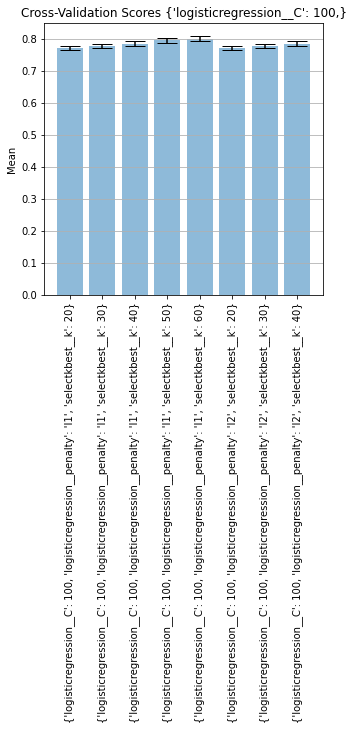

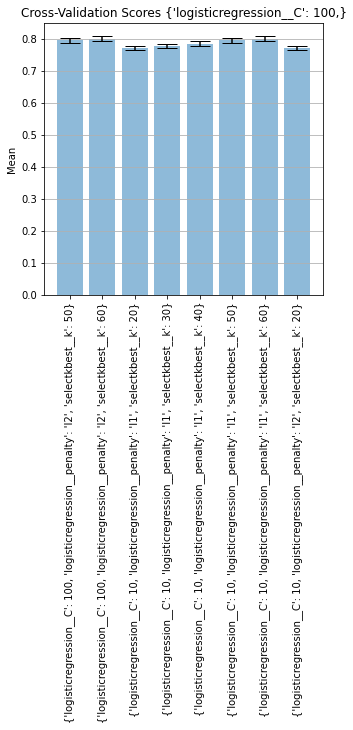

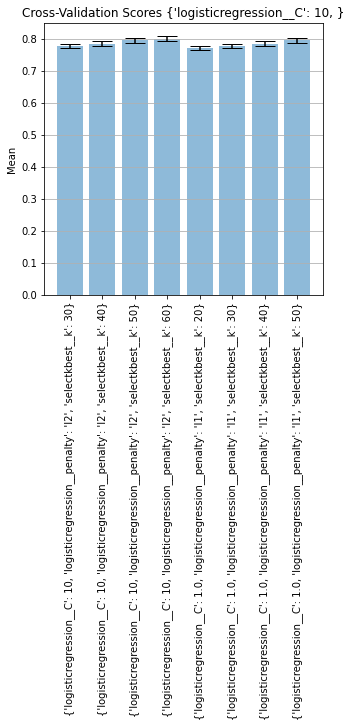

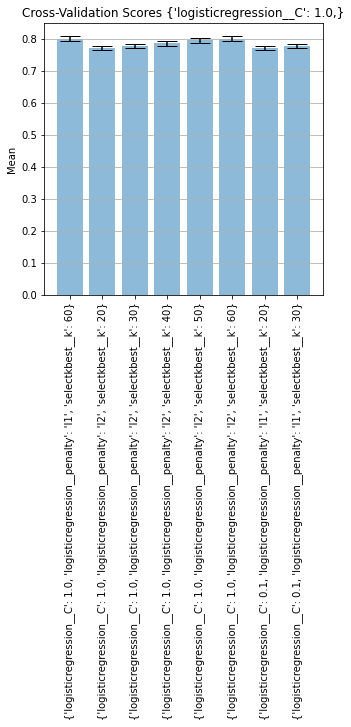

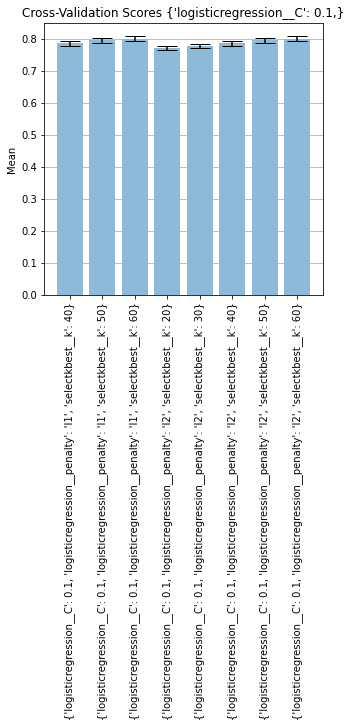

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,len(grid_result.cv_results_['params']),8):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.bar(np.arange(len(grid_result.cv_results_['params'][i:i+8])),
           grid_result.cv_results_['mean_test_score'][i:i+8],
           yerr=grid_result.cv_results_['std_test_score'][i:i+8],
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Mean')
    ax.set_xticks(np.arange(len(grid_result.cv_results_['params'][i:i+8])))
    ax.set_xticklabels(grid_result.cv_results_['params'][i:i+8], 
                       rotation=90)
    ax.set_title('Cross-Validation Scores '+str(grid_result.cv_results_['params'][i])[0:30]+'}')
    ax.yaxis.grid(True)

    #plt.savefig(r'D:\Maastricht\Machine Learning\Datasets\Dataset1\LogReg'+str(i)+'.png',
               #dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
from sklearn.neighbors import KNeighborsClassifier

# make a pipeline to select features and apply K Nearest Neighbors Classifier 
KNN_pipeline = make_pipeline(SelectKBest(score_func=f_classif), KNeighborsClassifier())

# k = number of features to choose in SelectKBest
k_values = [50]

# number of neighbors to use for k neighbors queries
#n_neighbors = range(100, 1000, 200)
n_neighbors = [1000]

# uniform: all points in each neighborhood are weighted equally.
# distance: weight points by the inverse of their distance. Closer neighbors of a query point 
# will have a greater influence than neighbors which are further away.
weights = ['uniform']

# distance metric to measure nearset points
metric = ['euclidean']

# 5-fold cross-validation 
cv = StratifiedKFold(n_splits=5)

grid = dict(kneighborsclassifier__n_neighbors=n_neighbors, 
            kneighborsclassifier__weights=weights, 
            kneighborsclassifier__metric=metric, 
            selectkbest__k=k_values)

# GridSearchCV exhaustively generates candidates from a grid of parameter values
grid_search = GridSearchCV(estimator=KNN_pipeline, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', 
error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# define a K Nearest Neighbors model using the optimal parameter values obtained from the grid search
KNN_pipeline = make_pipeline(SelectKBest(score_func=f_classif, k=grid_result.best_params_['selectkbest__k']), 
                        KNeighborsClassifier(metric=grid_result.best_params_['kneighborsclassifier__metric'], 
                                n_neighbors=grid_result.best_params_['kneighborsclassifier__n_neighbors'],
                                             weights=grid_result.best_params_['kneighborsclassifier__weights']))

In [5]:
from sklearn.ensemble import RandomForestClassifier

# make a pipeline to select features and apply Random Forest Classifier 
RF_pipeline = make_pipeline(SelectKBest(score_func=f_classif), RandomForestClassifier())

# k = number of features to choose in SelectKBest
k_values = [30, 40, 50, 60]

# number of neighbors to use for k neighbors queries
n_estimators = [500, 1000, 1500]

min_samples_split = [20, 50, 100]

# 5-fold cross-validation 
cv = StratifiedKFold(n_splits=5)

grid = dict(randomforestclassifier__n_estimators=n_estimators, 
            randomforestclassifier__min_samples_split=min_samples_split,  
            selectkbest__k=k_values)

# GridSearchCV exhaustively generates candidates from a grid of parameter values
grid_search = GridSearchCV(estimator=RF_pipeline, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', 
error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# define a Random Forest model using the optimal parameter values obtained from the grid search
KNN_pipeline = make_pipeline(SelectKBest(score_func=f_classif, 
                                k=grid_result.best_params_['selectkbest__k']), 
                        RandomForestClassifier(
                        n_estimators=grid_result.best_params_['randomforestclassifier__n_estimators'],
                min_samples_split=grid_result.best_params_['randomforestclassifier__min_samples_split']))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=50, 
max_features='auto', bootstrap=True, n_jobs=-1, random_state=20)

rf.fit(X_train, y_train)

sorted_idx = rf.feature_importances_.argsort()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 18))
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
from sklearn.metrics import accuracy_score

pred = rf.predict(X_test)
print(f"accuracy score voting is {accuracy_score(y_test, pred)}")

In [ ]:
prob = rf.predict_proba(unlabeled)[:,1]

submission = pd.DataFrame({'encounter_id': unlabeled['encounter_id'].astype(int), 'hospital_death': prob})

print(len(prob))
print(len(unlabeled['encounter_id']))

In [ ]:
submission.to_csv("submission.csv", index=False)